<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/Project_4_Notebook_cfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Grade**: 97%

**Comments**: Excellent work. I loved how you thought carefully about data cleaning for both the CSV and the Wikipedia page. I also really liked your word cloud comparison! I would've liked a bit more discussion on some of the results: Did the rankings make sense? Do you have any thoughts on why certain people were considered neighbors? What similarities/differences did you notice in the word clouds? 

# Problem Definition

The purpose of this project is to use Natural Language Processing techniques to determine sentiment and proximity of celebrities to each other based on descriptions of each celebrity.

**Goals:**

* Step 1
  * Provide a name of one person (target) from a supplied list.
  * Output the sentiment of the overview of the chosen celebrity.
  * Output 10 other people whose overviews are closest **(nearness)** in a Natural Language Processing sense.
* Step 2
  * Use the Wikipedia API to access the content of the chosen celebrity's wiki page.
  * Determine the sentiment of the wiki page content.
  * Print out the wiki article.
  * Collect wiki pages from the 10 nearest neighbors found in Step 1.
  * Determine nearness ranking of the 10 to the primary subject based on the entire wiki page.
  * Compare the nearest ranking from Step 1 with the Wiki page nearness ranking.

**Deliverables**
* Project Slides
* Code demonstration using a person suggested by another student.

## Imports

In [ ]:
# Install textblob to get sentiment scores
!pip3 install -U textblob

In [ ]:
# Install Wikipedia API to access wiki pages
!pip3 install wikipedia-api

  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-py3-none-any.whl size=13475 sha256=2bfbd7b55d0fc9c98f1d12c7f1dfd6950e0d5e433c346d574471b357e31b9fe0
  Stored in directory: /root/.cache/pip/wheels/d3/24/56/58ba93cf78be162451144e7a9889603f437976ef1ae7013d04
Successfully built wikipedia-api


In [ ]:
# Install text vectorizers to get proximity scores
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
# Install wordcloud library
!pip3 install wordcloud

In [ ]:
# grab the imports needed for the project
import numpy as np
import pandas as pd
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import wikipediaapi
import string

# Global Functions

In [ ]:
# https://stackabuse.com/how-to-print-colored-text-in-python/
def print_in_color(text, color="black"):
  BOLD = '\033[1m'
  PURPLE = '\033[35m'
  BLUE = '\033[34m'
  GREEN = '\033[32m'
  BLACK = '\033[30m'
  RED = '\033[31m'
  CYAN = '\033[36m'

  color = color.lower()
  codes = BOLD

  # Set chosen color
  if color == "blue":
    codes += BLUE
  elif color == "purple":
    codes += PURPLE
  elif color == "green":
    codes += GREEN
  elif color == "red":
    codes += RED
  elif color == "cyan":
    codes += CYAN
  else:
    codes += BLACK

  print(codes + text)

# Step 1 - Get Nearness and Sentiment

**Nearness** will be used to get the relevance of words for each candidate and then compared to relevance scores for other candidates to determine similarity between candidates. This will be achieved using the K-Nearest Neighbors in conjunction with Term Frequency-Inverse Document Frequency (TF-IDF) to evaluate the Corpus (body of text) for each candidate to get scores that can be used to get the top 10 candidates that come closest to the target candidate.

**Sentiment** describes polarity (negative or positive) and subjectivity (objective or subjective) for the text. This will be achieved using the TextBlob library.

## Load Data

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Load Data
data_path = '/drive/My Drive/Cohort_6/Projects/Project 4/Data/Project_4.csv'
data = pd.read_csv(data_path)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


In [ ]:
# Control length of text column displayed.
pd.options.display.max_colwidth = 50

In [ ]:
data.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


## Data Cleaning

The following data cleaning steps were not performed because the csv file that was supplied appeared to already have been cleaned.

* No capital letters
* No return characters
* No possessives or apostrophes.

However, after transforming the data using the TfidVectorizor, the resulting feature names contained a large number of numeric feature names due to isbn numbers and other numbers in the text. I spot checked the numbers and determined that they were not likely to contribute positively to the NLP Nearness result. So I removed numbers from the text.

*Note: it is possible that dates could be useful, but they were in a format that appeared difficult to parse so even the day and year data was removed leaving only the textual month remaining.*

In [ ]:
# Remove numbers from the text retaining only alpha characters.
data['text'] = data['text'].str.replace('\d+', '')

## Select Target Person

I searched the raw csv file for people who shared my birthday and then chose a candidate that I found interesting - **Tad Williams** - a science fiction/fantasy author.

In [ ]:
# TODO: deal with encoded values like smail beiki - record 17852
target = 'brad pitt'

neighbor_count = 10

## Get Sentiment

In [ ]:
# Convert all data to text blob so sentiment can be retrieved.
# Plagiarized code from Ellie for converting all data to text blobs.

# Note: if trying to apply TextBlob to a column, it is datatype=pd.Series which must be
#  first converted to_string() to apply TextBlob.
#  If using apply/lambda, then the value is string (excludes index) to which TextBlob
#  can be applied. Yay Ellie for the below code!

# Get all text into textblob format.
data['text_blob'] = data['text'].apply(lambda x: TextBlob(x))


In [ ]:
# Identify index of selected celebrity
# [0][0] is because np.where returns multi-dimensional array of indices.
#   so index is at position [0][0] in this case because we have one match.
target_index = np.where(data['name'].str.lower() == target)[0][0]

# Perform sentiment analysis for that celebrity
sent = data['text_blob'][target_index].sentiment
print_in_color(f'Polarity={round(sent.polarity,3)}', 'purple')
print_in_color(f'Subjectivity={round(sent.subjectivity,3)}', 'blue')

Polarity=0.302
Subjectivity=0.364


## Get Nearness Ranking

The following code uses the K-Nearest Neighbors algorithm in conjunction with Term Frequency-Inverse Document Frequency (TF-IDF) to evaluate the Corpus (body of text) for each candidate. 

The TfidTransformer was used to accommodate the large data size.

The top 10 nearest neighbors to the target will be selected from the resulting scores.

In [ ]:
# Convert text data into a very long array of strings
data_text = data['text'].to_numpy()
data_text

array(['digby morrell born  october  is a former australian rules footballer who played with the kangaroos and carlton in the australian football league aflfrom western australia morrell played his early senior football for west perth his game senior career for the falcons spanned  and he was the clubs leading goalkicker in  at the age of  morrell was recruited to the australian football league by the kangaroos football club with its third round selection in the  afl rookie draft as a forward he twice kicked five goals during his time with the kangaroos the first was in a losing cause against sydney in  and the other the following season in a drawn game against brisbaneafter the  season morrell was traded along with david teague to the carlton football club in exchange for corey mckernan he played  games for the blues before being delisted at the end of  he continued to play victorian football league vfl football with the northern bullants carltons vflaffiliate in  and acted as playing

In [ ]:
# Use TFID Transformer because it is better for big datasets.
tf_idf_vec = TfidfTransformer()
# Ignore english language stop words - and, the, an, of, etc.
cv = CountVectorizer(stop_words='english')
vec = cv.fit_transform(data_text)
tf_idf_pop = tf_idf_vec.fit_transform(vec)

In [ ]:
# Identify n neighbors who are nearest to the target celebrity.
target_blurb = tf_idf_pop[target_index]
nn = NearestNeighbors().fit(tf_idf_pop)
distances1, indices1 = nn.kneighbors(target_blurb, n_neighbors = neighbor_count)

In [ ]:
# Look at distances to get a feel for how close the matches were.
distances1

array([[0.        , 1.17157037, 1.20932714, 1.21078913, 1.21421195,
        1.21859387, 1.23277983, 1.23638689, 1.23884645, 1.24030839]])

In [ ]:
indices1

array([[24426, 39515, 16242, 28070, 42093, 37466, 21011, 34750, 37595,
        29556]])

In [ ]:
# Control length of displayed text
pd.options.display.max_colwidth = 1000
# Use indices to get list of 10 closest neighbors
nearest_data = data.iloc[indices1[0]]
nearest_data[['name','text']]

,name,text
24426,Brad Pitt,william bradley brad pitt born december is an american actor and producer he has received a golden globe award a screen actors guild award and three academy award nominations in acting categories and received two further academy award nominations winning one for productions of his film production company plan b entertainment he has been described as one of the worlds most attractive men a label for which he has received substantial media attentionpitt first gained recognition as a cowboy hitchhiker in the road movie thelma louise his first leading roles in bigbudget productions came with the dramas a river runs through it and legends of the fall and interview with the vampire he gave critically acclaimed performances in the crime thriller seven and the science fiction film monkeys both the latter earning him a golden globe award for best supporting actor and an academy award nomination pitt starred in the cult film fight club and the major international hit oceans eleven ...
39515,Angelina Jolie,angelina jolie doli johlee born angelina jolie voight june is an american actress director producer writer and humanitarian she has won an academy award two screen actors guild awards and three golden globe awards and has been cited as hollywoods highestpaid actress jolie made her screen debut as a child alongside her father jon voight in lookin to get out her film career began in earnest a decade later with the lowbudget production cyborg followed by her first leading role in a major film hackers she starred in the critically acclaimed biographical television films george wallace and gia and won an academy award for best supporting actress for her performance in the drama girl interrupted jolies starring role as the video game heroine lara croft in lara croft tomb raider established her as a leading hollywood actress she continued her successful actionstar career with mr mrs smith wanted and salt and received critical acclaim for her performances in the dramas a might...
16242,Meryl Streep,meryl streep born mary louise streep june is an american actress and producer a threetime academy award winner she is widely regarded as one of the greatest film actors of all time streep made her professional stage debut in the playboy of seville in and went on to receive a tony award nomination for best featured actress in a play for a memory of two mondays wagons full of cotton she made her screen debut in the television film the deadliest season and made her film debut later that same year in julia in she won an emmy award for her role in the miniseries holocaust and received the first of her academy award nominations for the deer hunter she has more academy award nominations than any actor or actress in history winning best supporting actress for kramer vs kramer and best actress for sophies choice and the iron lady streep is one of only six actors who have won three or more competitive academy awards for acting her other nominated roles include the french lieutenants...
28070,Amy Adams,amy lou adams born august is an american actress and singer adams began her career on stage performing in dinner theatre and later made her feature film debut in drop dead gorgeous after moving to los angeles and appearing in a series of television guest appearances and roles in b movies adams appeared as brenda strong in steven spielbergs frank abagnale biopic catch me if you can her breakthrough role came in the independent film junebug for which she received critical acclaim and her first of four academy award nominations for best supporting actress in adams starred in the disney animated musical film enchanted a critical and commercial success and received a golden globe award nomination for her lead performance she received her second academy award and golden globe nominations and first bafta award nomination for her supporting role in the film doubtadams received two more golden globe bafta and academy award nominations for her s

# Step 2 - Wikipedia Analysis


## Load Wiki Pages

In [ ]:
# Put underscore in name so matches wiki page name.
nearest_data['wiki_name'] = nearest_data['name'].str.replace(' ','_')

# Create instance of wiki object for english language
wiki_obj = wikipediaapi.Wikipedia('en')

# Get wiki entire page text for target and nearest neighbors.
nearest_data['wiki_text'] = nearest_data['wiki_name'].apply(lambda x: wiki_obj.page(x).text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Control length of displayed text
pd.options.display.max_colwidth = 50
nearest_data.info()
nearest_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 24426 to 29556
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   URI        10 non-null     object
 1   name       10 non-null     object
 2   text       10 non-null     object
 3   text_blob  10 non-null     object
 4   wiki_name  10 non-null     object
 5   wiki_text  10 non-null     object
dtypes: object(6)
memory usage: 560.0+ bytes


,URI,name,text,text_blob,wiki_name,wiki_text
24426,<http://dbpedia.org/resource/Brad_Pitt>,Brad Pitt,william bradley brad pitt born december is a...,"(w, i, l, l, i, a, m, , b, r, a, d, l, e, y, ...",Brad_Pitt,"William Bradley Pitt (born December 18, 1963) ..."
39515,<http://dbpedia.org/resource/Angelina_Jolie>,Angelina Jolie,angelina jolie doli johlee born angelina jolie...,"(a, n, g, e, l, i, n, a, , j, o, l, i, e, , ...",Angelina_Jolie,"Angelina Jolie (; née Voight, formerly Jolie ..."
16242,<http://dbpedia.org/resource/Meryl_Streep>,Meryl Streep,meryl streep born mary louise streep june is...,"(m, e, r, y, l, , s, t, r, e, e, p, , b, o, ...",Meryl_Streep,"Mary Louise ""Meryl"" Streep (born June 22, 1949..."
28070,<http://dbpedia.org/resource/Amy_Adams>,Amy Adams,amy lou adams born august is an american act...,"(a, m, y, , l, o, u, , a, d, a, m, s, , b, ...",Amy_Adams,"Amy Lou Adams (born August 20, 1974) is an Ame..."
42093,<http://dbpedia.org/resource/Gwyneth_Paltrow>,Gwyneth Paltrow,gwyneth kate paltrow wn pltro born september ...,"(g, w, y, n, e, t, h, , k, a, t, e, , p, a, ...",Gwyneth_Paltrow,Gwyneth Kate Paltrow (; born (1972-09-27)Septe...


## Data Cleaning

In addition to [class notes](https://colab.research.google.com/drive/11i8lNqqTROTVpb-QZh-n4a_rEe6AAF4W#scrollTo=KNCVOwBS1AVL), I used [this article](https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470) to perform additional data cleaning.

**Steps:**
* Removed numbers.
* Removed punctuation and line returns.
* Lemmatized.

I did not remove stop words as it appeared that the NLP process will handle this.


In [ ]:
# Get rid of unneeded characters, line returns, possessives, punctuation.
def removePunctuation(text):
  no_punct=[word for word in text if word not in string.punctuation]
  words_wo_punct=''.join(no_punct)
  return words_wo_punct

# TODO: confirm if lemmatize is working
def doLemmatize(text):
  clean=[Word(word).lemmatize() for word in text]
  return ''.join(clean)

nearest_data['wiki_text_clean'] = nearest_data['wiki_text'].str.replace("\n"," ").replace("\'s",'').replace('\'','')
nearest_data['wiki_text_clean'] = nearest_data['wiki_text_clean'].apply(lambda x: removePunctuation(x))

# TODO: see if can use regex to remove isbn + 9 digits and other number patterns
nearest_data['wiki_text_clean'] = nearest_data['wiki_text_clean'].str.replace('\d+', '')
nearest_data['wiki_text_clean'] = nearest_data['wiki_text_clean'].apply(lambda x: doLemmatize(x))
nearest_data['wiki_text_clean'] = nearest_data['wiki_text_clean'].apply(lambda x: x.lower())

# TODO: do I need to tokenize or is that already handled in the nearness tool.
# TODO: what do all the warnings mean? 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
# Control length of displayed text
pd.options.display.max_colwidth = 500
nearest_data[['wiki_text','wiki_text_clean']]

,wiki_text,wiki_text_clean
24426,"William Bradley Pitt (born December 18, 1963) is an American actor and film producer. He is the recipient of numerous accolades, including an Academy Award, a British Academy Film Award, and two Golden Globe Awards for his acting, in addition to a second Academy Award, a second British Academy Film Award, a third Golden Globe Award, and a Primetime Emmy Award as a producer under his production company, Plan B Entertainment.\nPitt first gained recognition as a cowboy hitchhiker in the road fi...",william bradley pitt born december is an american actor and film producer he is the recipient of numerous accolades including an academy award a british academy film award and two golden globe awards for his acting in addition to a second academy award a second british academy film award a third golden globe award and a primetime emmy award as a producer under his production company plan b entertainment pitt first gained recognition as a cowboy hitchhiker in the road film thelma louise h...
39515,"Angelina Jolie (; née Voight, formerly Jolie Pitt; born June 4, 1975) is an American actress, filmmaker, and humanitarian. The recipient of numerous accolades, including an Academy Award and three Golden Globe Awards, she has been named Hollywood's highest-paid actress multiple times.\nJolie made her screen debut as a child alongside her father, Jon Voight, in Lookin' to Get Out (1982), and her film career began in earnest a decade later with the low-budget production Cyborg 2 (1993), follo...",angelina jolie née voight formerly jolie pitt born june is an american actress filmmaker and humanitarian the recipient of numerous accolades including an academy award and three golden globe awards she has been named hollywoods highestpaid actress multiple times jolie made her screen debut as a child alongside her father jon voight in lookin to get out and her film career began in earnest a decade later with the lowbudget production cyborg followed by her first leading role in a majo...
16242,"Mary Louise ""Meryl"" Streep (born June 22, 1949) is an American actress. Often described as ""the best actress of her generation"", Streep is particularly noted for her versatility and accent adaptability. She is the recipient of numerous accolades, including a record 21 Academy Award nominations, winning three (behind only Katharine Hepburn for the world-record), and a record 32 Golden Globe Award nominations, winning eight.Streep made her stage debut in Trelawny of the Wells and received a To...",mary louise meryl streep born june is an american actress often described as the best actress of her generation streep is particularly noted for her versatility and accent adaptability she is the recipient of numerous accolades including a record academy award nominations winning three behind only katharine hepburn for the worldrecord and a record golden globe award nominations winning eightstreep made her stage debut in trelawny of the wells and received a tony award nomination for wag...
28070,"Amy Lou Adams (born August 20, 1974) is an American actress. Known for both comedic and dramatic roles, she has featured three times in annual rankings of the world's highest-paid actresses. She has received various accolades throughout her career, including a Screen Actors Guild Award and two Golden Globe Awards, in addition to nominations for six Academy Awards and seven British Academy Film Awards.\nBorn in Vicenza, Italy, and raised in Castle Rock, Colorado, Adams is the fourth of seven ...",amy lou adams born august is an american actress known for both comedic and dramatic roles she has featured three times in annual rankings of the worlds highestpaid actresses she has received various accolades throughout her career including a screen actors guild award and two golden globe awards in addition to nominations for six academy awards and seven british academy film awards born in vicenza italy and raised in castle rock colorado adams is th

In [ ]:
# Create TextBlob from cleaned data for further cleaning and to get sentiment
nearest_data['wiki_blob'] = nearest_data['wiki_text_clean'].apply(lambda x: TextBlob(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Print Target Wiki Page

In [ ]:
print(nearest_data['wiki_text'].iloc[0])

William Bradley Pitt (born December 18, 1963) is an American actor and film producer. He is the recipient of numerous accolades, including an Academy Award, a British Academy Film Award, and two Golden Globe Awards for his acting, in addition to a second Academy Award, a second British Academy Film Award, a third Golden Globe Award, and a Primetime Emmy Award as a producer under his production company, Plan B Entertainment.
Pitt first gained recognition as a cowboy hitchhiker in the road film Thelma & Louise (1991). His first leading roles in big-budget productions came with the drama films A River Runs Through It (1992) and Legends of the Fall (1994), and the horror film Interview with the Vampire (1994). He gave critically acclaimed performances in the crime thriller Seven (1995) and the science fiction film 12 Monkeys (1995), the latter earning him a Golden Globe Award for Best Supporting Actor and an Academy Award nomination.
Pitt starred in Fight Club (1999) and the heist film Oce

## Get Sentiment for Target Wiki Page

In [ ]:
# Perform sentiment analysis for target celebrity. Target celibrity is first one in the list.
sent = nearest_data['wiki_blob'].iloc[0].sentiment
print_in_color(f'Polarity={round(sent.polarity,3)}', 'purple')
print_in_color(f'Subjectivity={round(sent.subjectivity,3)}', 'blue')

Polarity=0.141
Subjectivity=0.37


## Get Nearness Ranking for Wiki Pages

In [ ]:
# Convert text data into a very long array of strings
wiki_text = nearest_data['wiki_text_clean'].to_numpy()

In [ ]:
# Use TFID Transformer to get data needed for nearness rankings
tf_idf_vec = TfidfTransformer()
# Ignore english language stop words - and, the, an, of, etc.
cv = CountVectorizer(stop_words='english')
vec = cv.fit_transform(wiki_text)
tf_idf_pop = tf_idf_vec.fit_transform(vec)

In [ ]:
# Identify n neighbors who are nearest to the target celebrity.
# target is based on previous nearest neighbors data so is in the first row at index 0.
target_blurb = tf_idf_pop[0]
nn = NearestNeighbors().fit(tf_idf_pop)
distances2, indices2 = nn.kneighbors(target_blurb, n_neighbors = neighbor_count)

In [ ]:
wiki_text[0]

'william bradley pitt born december   is an american actor and film producer he is the recipient of numerous accolades including an academy award a british academy film award and two golden globe awards for his acting in addition to a second academy award a second british academy film award a third golden globe award and a primetime emmy award as a producer under his production company plan b entertainment pitt first gained recognition as a cowboy hitchhiker in the road film thelma  louise  his first leading roles in bigbudget productions came with the drama films a river runs through it  and legends of the fall  and the horror film interview with the vampire  he gave critically acclaimed performances in the crime thriller seven  and the science fiction film  monkeys  the latter earning him a golden globe award for best supporting actor and an academy award nomination pitt starred in fight club  and the heist film oceans eleven  as well as its sequels oceans twelve  and oceans thirteen

# Conclusions

The first part of this project was to compute sentiment and nearness for pre-cleaned, summarized blocks of text and then do the same for full Wikipedia articles for the same subjects. 

Sentiment was more neutral for the summarized text blocks than for the full wiki pages. Nearness rankings shifted significantly for the summarized text versus the full wiki pages. I believe that the differences may have been caused by the following:

- Wiki pages were much longer than summarized text and contained a wider variety of topics. It appears that once text exceeds a certain length, or variety of topics, NLP processing will produce different results.
- The summarized data had already been cleaned. I cleaned the wiki pages and therefore may have overlooked some cleaning that, when applied, may lead to different results.



## Compare Target WordCloud for Summary and Wiki

*Note: I borrowed this idea from Amy.*

[Link used to produce WordClouds](https://www.geeksforgeeks.org/generating-word-cloud-python/)

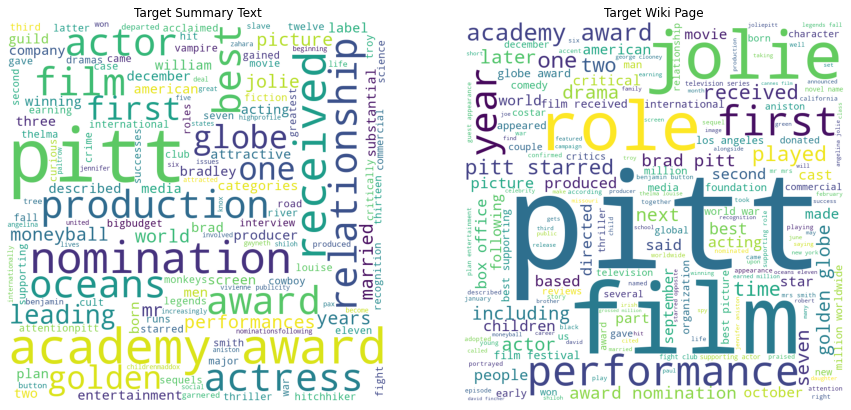

In [ ]:
# Get array of stopwords to eliminate from wordcloud result
stopwords = set(STOPWORDS)

# Plot wordcloud for target summary text
wc_sum = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(data_text[target_index])

# Plot wordcloud for target wiki page.
wc_wiki = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(wiki_text[0])

# Plot both side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,15))
plot_sum = ax1.imshow(wc_sum)
ax1.set_title('Target Summary Text')
ax1.axis("off")

plot_wiki = ax2.imshow(wc_wiki)
ax2.set_title('Target Wiki Page')
ax2.axis("off")
 
plt.show()

# TODO: sort texts and do bar plot of top counts.

## Compare Sentiments

Sentiment describes polarity (negative or positive) and subjectivity (objective-0 or subjective-1) for the text. 

For both the summary text and the wiki page, polarity was close to zero indicating that the text was neither negative nor positive. 

For both the summary text and the wiki page, subjectivity was closer to 0 than to 1 indicating both texts were objective. The wiki page was closer to the midpoint indicating that the wiki was slightly more subjective than the summary text.

In [ ]:
# From summary
sent = data['text_blob'][target_index].sentiment
print_in_color('Text Sentiment:')
print_in_color(f'Polarity={round(sent.polarity,3)}', 'purple')
print_in_color(f'Subjectivity={round(sent.subjectivity,3)}', 'blue')

print()

# From wiki page
sent = nearest_data['wiki_blob'].iloc[0].sentiment
print_in_color('Wiki Sentiment:')
print_in_color(f'Polarity={round(sent.polarity,3)}', 'purple')
print_in_color(f'Subjectivity={round(sent.subjectivity,3)}', 'blue')

Text Sentiment:
Polarity=0.302
Subjectivity=0.364

Wiki Sentiment:
Polarity=0.141
Subjectivity=0.37


## Compare Nearness Rankings

Nearness rankings for the summarized text were compared to nearness rankings for the cleaned wiki pages. The results show the old rank compared to the new rank. The results show:

- Ranking numbers increased overall from an average of 1.32 to 1.36 for the summarized text compared to the wiki text indicating that the wiki text was slightly less correlated.
- The first two items were still a close match but the ranking order differed considerably for the third through 10th neighbors.


In [ ]:
# Combine nearness rankings for comparison

# Transform step 1 nearness rankings into dataframe.
# Capture old ranking - which is index because data sorted in rank order.
narr1 = np.transpose(np.array([distances1[0],indices1[0]]))
ndf1 = pd.DataFrame(data=narr1, columns=['distance1','index1'])
ndf1['oldrank'] = ndf1.index

# Transform step 2 nearness rankings into dataframe
# Capture new ranking - which is index because data sorted in rank order.
narr2 = np.transpose(np.array([distances2[0],indices2[0]]))
ndf2 = pd.DataFrame(data=narr2, columns=['distance2','oldrank'])  # index2 is same as old rank value.
ndf2['newrank'] = ndf2.index

# Combine two sets of nearness rankings to compare 
ndf = pd.merge(ndf1, ndf2, on='oldrank')
ndf


,distance1,index1,oldrank,distance2,newrank
0,0.000000,24426.0,0,0.000000,0
1,1.171570,39515.0,1,1.107209,1
2,1.209327,16242.0,2,1.281114,6
3,1.210789,28070.0,3,1.267040,5
4,1.214212,42093.0,4,1.260962,4
5,1.218594,37466.0,5,1.166509,2
6,1.232780,21011.0,6,1.309887,9
7,1.236387,34750.0,7,1.205007,3
8,1.238846,37595.0,8,1.303039,7
9,1.240308,29556.0,9,1.307350,8


## Additional Work

I would like to experiment with additional data cleaning of the wiki pages - lemmatization and tokenization - to see if this has an impact on rankings. I would also like to remove some sections from the wiki page to see if this brings the ranking more into line with the original summarized text rankings.